# IBM Applied Data Science Capstone
<hr>

1. Community Areas Defined
    - Community Area - Wikipedia
    - Population - HousingStudies.org
    - Median Household - Wikipedia
    - Forclosures - HousingStudies.org
    - Mortgages - HousingStudies.org
    - Poverty Rate - HousingStudies.org
    - Tree Canopy - edirepository.org
2. Community Area Clustering
    - Trim and Standardize
    - Find optimal cluster count
3. Map Clusters and analyze
    - Lowest Forclosures to Mortgages rate
    - Highest Tree Canopy percentage
4. Foursquare Venue Data per Community Area
    - Standardize for analysis
5. Analyze Venue Data
    - In demand public venues and facilities
    - Correlations

<hr>

---Tree Data Citation---<br>
link:<br>
https://portal.edirepository.org/nis/mapbrowse?packageid=knb-lter-bes.5008
<br>
Citation:<br>
Locke, D.H. 2020. Residential housing segregation and urban tree canopy in 37 US Cities; <br>
data in support of Locke et al 2020 in npj Urban Sustainability ver 1. Environmental Data Initiative. <br> https://doi.org/10.6073/pasta/907a557cac781eb4cf72f866a2903c04 (Accessed 2021-03-01).

<hr>

---Housing Data Citation---<br>
link:<br>
https://www.housingstudies.org/data-portal/browse/?indicator=poverty-rate&area=chicago-community-areas&view_as=view-table
link:<br>
https://www.housingstudies.org/data-portal/browse/?indicator=total-foreclosure-activity&area=chicago-community-areas&property_type=0&view_as=view-table

<hr>

In [7]:
#Libraries
import pandas as pd
import numpy as np
import geopandas as gdp
import requests
from bs4 import BeautifulSoup
import geocoder
from datetime import date
import json
from pandas.io.json import json_normalize
import folium
import geojson
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [8]:
def rawnum(numstr):

    for x in range(0, len(numstr)-1):
        if numstr[x]=="[":
            numstr = numstr[0:x]
            break
            
    for x in range(len(numstr)-1, -1, -1):
        if not numstr[x].isnumeric():
            if numstr[x]==".":
                continue
            else:
                numstr = numstr.replace(numstr[x],"")
    
    return numstr

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
#Foursquare
CLIENT_ID = 'PP1YWJZLGPAOTV0JRPJ2COQZ0BLXXAXR1WVR2M12OHN3WPIE' # your Foursquare ID
CLIENT_SECRET = '3WHMP4NQPMAAAURF5FGSVT2G43UDH3TTQJDGWGJTWMILA3TO' # your Foursquare Secret
VERSION = date.today().strftime("%Y%m%d")
LIMIT = 100 # A default Foursquare API limit value

## 1.) Community Areas Defined
Data Pulled in seperate notebooks and saved to csv for ease of reading<br><br>
Notebook sources in github:<br> 
Github location:<br>
https://github.com/toaster515/Applied-Data-Science-Capstone
<br><br>
Notebooks:<br>
Chi_Comm_Characteristics.ipynb<br>
Capstone_GetCommunityAreas.ipynb<br>
<hr>

In [11]:
df_comm = pd.read_csv('Chi_Comm_Character.csv')
df_comm

,Geography,Total Population,Poverty,Forclosures,Mortgages
0,Albany Park,49806,8068.572,114,2333
1,Archer Heights,13726,2058.900,58,495
2,Armour Square,13538,4440.464,8,473
3,Ashburn,43356,5549.568,618,2785
4,Auburn Gresham,45909,11660.886,764,2315
...,...,...,...,...,...
72,West Lawn,31886,4336.496,253,1506
73,West Pullman,27028,6189.412,465,1149
74,West Ridge,78466,16948.656,208,3554
75,West Town,83757,8961.999,185,10002


In [12]:
df = pd.read_csv('ChicagoCommunityAreas2.csv')
df

,Geography,Income,Lat,Long,TreeCover,TreePolygon
0,Chatham,32222.0,41.74000,-87.61167,24.599942,B118
1,Austin,31634.0,41.90000,-87.76000,28.814417,C108
2,Beverly,98416.0,41.71000,-87.68000,46.259805,B124
3,Morgan Park,60747.0,41.69000,-87.67000,24.867890,D109
4,Woodlawn,26415.0,41.78000,-87.60000,15.644162,D79
...,...,...,...,...,...,...
72,O'Hare,49295.0,42.00000,-87.92000,0.000000,0
73,Chicago Lawn,33122.0,41.77000,-87.69000,17.409443,C209
74,Loop,107246.0,41.88194,-87.62778,0.000000,0
75,North Park,54828.0,41.98370,-87.71920,29.694929,B61


In [13]:
df2 = df_comm.set_index('Geography').join(df.set_index('Geography'))
df2.tail(50)

,Total Population,Poverty,Forclosures,Mortgages,Income,Lat,Long,TreeCover,TreePolygon
Geography,,,,,,,,,
Garfield Ridge,37207,3162.595,241,2826,49773.18182,41.79330,-87.78160,14.915927,C199
Grand Boulevard,22643,6543.827,212,1400,32348.00000,41.81000,-87.62000,14.114550,D74
Greater Grand Crossing,30149,10280.809,447,1388,26515.00000,41.76000,-87.61000,20.548229,C237
Hegewisch,9089,1663.287,55,533,50338.00000,41.66000,-87.55000,19.660525,D122
Hermosa,23481,3921.327,98,854,39157.00000,41.92000,-87.73000,17.940105,C113
Humboldt Park,55364,14007.092,331,1944,49773.18182,41.88000,-87.70000,14.951116,D26
Hyde Park,27482,6101.004,92,1153,54140.00000,41.80000,-87.59000,24.559338,C215
Irving Park,53530,4871.230,149,4097,64598.00000,41.95000,-87.73000,27.496558,C50
Jefferson Park,27503,2640.288,110,2137,76054.00000,41.98000,-87.77000,23.966615,C45


In [14]:
df2 = df2.reset_index()

In [15]:
df2.columns.values[1]='Population'
df2.columns

Index(['Geography', 'Population', 'Poverty', 'Forclosures', 'Mortgages',
       'Income', 'Lat', 'Long', 'TreeCover', 'TreePolygon'],
      dtype='object')

In [16]:
address = 'North Center, Chicago Illinois'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Geograpical coordinates are {}, {}.'.format(latitude, longitude))

Geograpical coordinates are 41.8586566, -87.6121985.


In [17]:
map_can = folium.Map(location=[latitude, longitude], zoom_start=10)

for neighborhood, lat, lng in zip(df2['Geography'], df2['Lat'], df2['Long']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_can)  

map_can

## 2.) Community Area Clustering
<hr>

In [18]:
df_clus = df2.drop(['Geography', 'Lat', 'Long','TreePolygon'], axis=1)
df_clus.head()

,Population,Poverty,Forclosures,Mortgages,Income,TreeCover
0,49806,8068.572,114,2333,59883.0,20.428704
1,13726,2058.900,58,495,44109.0,13.618029
2,13538,4440.464,8,473,27464.0,10.569697
3,43356,5549.568,618,2785,63573.0,17.109188
4,45909,11660.886,764,2315,29389.0,16.864916


In [19]:
X = df_clus.values[:,1:]
X = np.nan_to_num(df_clus)
Clus_dataSet = StandardScaler().fit_transform(X)

In [20]:
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

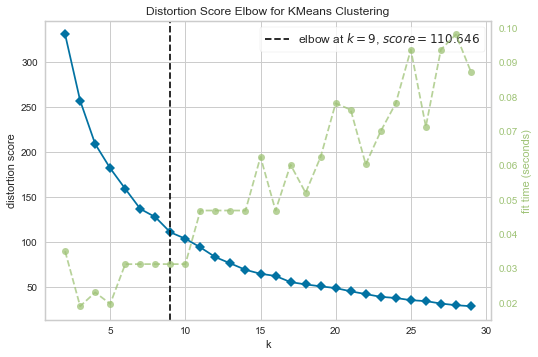

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(Clus_dataSet)       
visualizer.show()

In [22]:
#Establish Cluster Count
chi_clus=6

In [23]:
#Cluster built on income, population size and race
kmeans = KMeans(n_clusters=chi_clus, random_state=0, n_init=12).fit(Clus_dataSet)
label = kmeans.labels_
df2['clus']=label

In [24]:
df2

,Geography,Population,Poverty,Forclosures,Mortgages,Income,Lat,Long,TreeCover,TreePolygon,clus
0,Albany Park,49806,8068.572,114,2333,59883.0,41.9700,-87.7200,20.428704,C55,0
1,Archer Heights,13726,2058.900,58,495,44109.0,41.8103,-87.7264,13.618029,D68,4
2,Armour Square,13538,4440.464,8,473,27464.0,41.8389,-87.6343,10.569697,D51,4
3,Ashburn,43356,5549.568,618,2785,63573.0,41.7500,-87.7100,17.109188,D84,1
4,Auburn Gresham,45909,11660.886,764,2315,29389.0,41.7429,-87.6557,16.864916,C233,1
...,...,...,...,...,...,...,...,...,...,...,...
72,West Lawn,31886,4336.496,253,1506,50384.0,41.7725,-87.7204,17.441757,C206,4
73,West Pullman,27028,6189.412,465,1149,33898.0,41.6800,-87.6300,33.491661,C269,1
74,West Ridge,78466,16948.656,208,3554,52039.0,42.0000,-87.6900,25.501405,B73,3
75,West Town,83757,8961.999,185,10002,96499.0,41.9000,-87.6800,18.602286,C156,5


In [25]:
df2.to_csv('ChiClustered.csv', index=False)

## 3.) Map Clusters and analyze

<hr>

In [26]:
from folium import Map, FeatureGroup, Marker, LayerControl

In [27]:
address = 'Chicago Illinois, USA'
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [89]:
f = folium.Figure(width=1000, height=900)
map_chi = folium.Map(location=[latitude, longitude], zoom_start=10, tiles='Stamen Toner').add_to(f)
c0 = FeatureGroup(name="Cluster_0")
c1 = FeatureGroup(name="Cluster_1")
c2 = FeatureGroup(name="Cluster_2")
c3 = FeatureGroup(name="Cluster_3")
c4 = FeatureGroup(name="Cluster_4")
c5 = FeatureGroup(name="Cluster_5")


for neighborhood, lat, lng, cluster in zip(df2['Geography'], df2['Lat'], df2['Long'], df2['clus']):
    label = folium.Popup(str(neighborhood) + ' Cluster: ' + str(cluster), parse_html=True)
    
    if cluster==0:
        folium.CircleMarker(
            [lat, lng],radius=5,popup=label,color='#1F618D',
            fill=True,fill_color='#1F618D',fill_opacity=0.6,parse_html=False).add_to(c0)  
        folium.Circle(
            [lat, lng],radius=1500,color='#A7D6E8',fill=False).add_to(c0)
    elif cluster==1:
        folium.CircleMarker(
            [lat, lng],radius=5,popup=label,color='#8E44AD',
            fill=True,fill_color='#8E44AD',fill_opacity=0.6,parse_html=False).add_to(c1)  
        folium.Circle(
            [lat, lng],radius=1500,color='#A7D6E8',fill=False).add_to(c1)
    elif cluster==2:
        folium.CircleMarker(
            [lat, lng],radius=5,popup=label,color='#FF0008',
            fill=True,fill_color='#FF0008',fill_opacity=0.6,parse_html=False).add_to(c2)  
        folium.Circle(
            [lat, lng],radius=1500,color='#A7D6E8',fill=False).add_to(c2)
    elif cluster==3:
        folium.CircleMarker(
            [lat, lng],radius=5,popup=label,color='#FBFF00',
            fill=True,fill_color='#FBFF00',fill_opacity=0.6,parse_html=False).add_to(c3)  
        folium.Circle(
            [lat, lng],radius=1500,color='#A7D6E8',fill=False).add_to(c3)
    elif cluster==4:
        folium.CircleMarker(
            [lat, lng],radius=5,popup=label,color='#7DCEA0',
            fill=True,fill_color='#7DCEA0',fill_opacity=0.6,parse_html=False).add_to(c4)  
        folium.Circle(
            [lat, lng],radius=1500,color='#A7D6E8',fill=False).add_to(c4)
    elif cluster==5:
        folium.CircleMarker(
            [lat, lng],radius=5,popup=label,color='#FF8300',
            fill=True,fill_color='#FF8300',fill_opacity=0.6,parse_html=False).add_to(c5)  
        folium.Circle(
            [lat, lng],radius=1500,color='#A7D6E8',fill=False).add_to(c5)
        
map_chi.add_child(c0)
map_chi.add_child(c1)
map_chi.add_child(c2)
map_chi.add_child(c3)
map_chi.add_child(c4)
map_chi.add_child(c5)
map_chi.add_child(folium.map.LayerControl())
map_chi

### Brief analysis using folium layer control and cluster data below:

In [29]:
df3 = df2.drop(['Lat', 'Long'], axis=1)
df3 = df3.groupby(['clus']).mean()
df3 = df3.sort_values(by='Income')
df3

,Population,Poverty,Forclosures,Mortgages,Income,TreeCover
clus,,,,,,
1,34265.307692,9135.112923,477.384615,1470.769231,34070.783217,21.694207
4,18645.062500,4076.919969,118.812500,813.843750,39574.750000,17.159290
3,69150.714286,17222.681714,364.000000,2599.857143,39794.597403,20.856551
0,45562.500000,5399.229417,151.500000,3465.000000,68186.765152,17.079920
2,21655.571429,1480.737857,91.714286,2113.142857,88921.285714,30.561541
5,80725.333333,9134.070500,184.666667,8336.666667,92215.000000,19.601560


In [30]:
df3['F_to_M'] = df3['Forclosures']/df3['Mortgages']
df3 = df3.sort_values(by='F_to_M')
df3

,Population,Poverty,Forclosures,Mortgages,Income,TreeCover,F_to_M
clus,,,,,,,
5,80725.333333,9134.070500,184.666667,8336.666667,92215.000000,19.601560,0.022151
2,21655.571429,1480.737857,91.714286,2113.142857,88921.285714,30.561541,0.043402
0,45562.500000,5399.229417,151.500000,3465.000000,68186.765152,17.079920,0.043723
3,69150.714286,17222.681714,364.000000,2599.857143,39794.597403,20.856551,0.140008
4,18645.062500,4076.919969,118.812500,813.843750,39574.750000,17.159290,0.145989
1,34265.307692,9135.112923,477.384615,1470.769231,34070.783217,21.694207,0.324582


## 4.) Foursquare Venue Data per Community Area
<hr>

In [31]:
chi_venues = getNearbyVenues(names=df['Geography'],
                                   latitudes=df['Lat'],
                                   longitudes=df['Long']
                                  )

Chatham
Austin
Beverly
Morgan Park
Woodlawn
West Garfield Park
Fuller Park
Lake View
Portage Park
Uptown
Norwood Park
Near North Side
West Ridge
Brighton Park
West Lawn
Washington Park
Jefferson Park
Irving Park
Montclare
Edgewater
Mount Greenwood
South Deering
Albany Park
Lincoln Park
Near South Side
North Lawndale
McKinley Park
Calumet Heights
Greater Grand Crossing
Kenwood
North Center
Belmont Cragin
West Pullman
Armour Square
South Shore
West Elsdon
Lincoln Square
Ashburn
Oakland
East Side
Hyde Park
South Lawndale
Dunning
West Englewood
Douglas
East Garfield Park
Garfield Ridge
Rogers Park
Grand Boulevard
South Chicago
Near West Side
Clearing
Avalon Park
Hegewisch
Burnside
Auburn Gresham
Hermosa
New City
Humboldt Park
Bridgeport
Archer Heights
Englewood
Lower West Side
Forest Glen
Avondale
Edison Park
Roseland
Riverdale
Gage Park
Logan Square
Pullman
Washington Heights
O'Hare
Chicago Lawn
Loop
North Park
West Town


In [32]:
# chi_venues = pd.read_csv('ChiVenues1.csv')

In [33]:
chi_venues.shape

(5256, 7)

In [34]:
chi_venues.drop_duplicates()
chi_venues.shape

(5256, 7)

In [35]:
#chi_venues.to_csv('ChiVenues1.csv')

In [36]:
chi_venues.columns

Index(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'],
      dtype='object')

### Standardize

In [37]:
chi_onehot = pd.get_dummies(chi_venues[['Venue Category']], prefix="", prefix_sep="")
chi_onehot['Neighborhood'] = chi_venues['Neighborhood']
fixed_columns = [chi_onehot.columns[-1]] + list(chi_onehot.columns[:-1])
chi_onehot = chi_onehot[fixed_columns]
chi_group = chi_onehot.groupby('Neighborhood').mean().reset_index()
chi_group.shape

(77, 350)

In [38]:
chi_onehot.shape

(5256, 350)

In [39]:
chi_group.head()
print(chi_group.shape)

(77, 350)


In [40]:
chi_onehot.to_csv('ChiOneHot1.csv')
chi_group.to_csv('ChiGroups1.csv')

### Top Venues per Community Area

In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [42]:
num_top_venues = 10

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
        columns.append("V:{}".format(ind+1))

# create a new dataframe
top_venues = pd.DataFrame(columns=columns)
top_venues['Neighborhood'] = chi_group['Neighborhood']

for ind in np.arange(chi_group.shape[0]):
    top_venues.iloc[ind, 1:] = return_most_common_venues(chi_group.iloc[ind, :], num_top_venues)

top_venues.shape

(77, 11)

In [43]:
top_venues

,Neighborhood,V:1,V:2,V:3,V:4,V:5,V:6,V:7,V:8,V:9,V:10
0,Albany Park,Pizza Place,Asian Restaurant,Coffee Shop,Park,Supermarket,Grocery Store,Mobile Phone Shop,Middle Eastern Restaurant,Mexican Restaurant,Bakery
1,Archer Heights,Mexican Restaurant,Sandwich Place,Mobile Phone Shop,Bank,Fast Food Restaurant,Storage Facility,Bar,Cosmetics Shop,Grocery Store,Discount Store
2,Armour Square,Chinese Restaurant,Pizza Place,Bar,Coffee Shop,Hot Dog Joint,Mexican Restaurant,Bakery,Grocery Store,Shipping Store,Sandwich Place
3,Ashburn,Fast Food Restaurant,Park,Bakery,Ice Cream Shop,Seafood Restaurant,Liquor Store,Furniture / Home Store,Bus Station,Gas Station,Shop & Service
4,Auburn Gresham,Fast Food Restaurant,Seafood Restaurant,Discount Store,Park,Pharmacy,Lounge,Sandwich Place,Southern / Soul Food Restaurant,Bar,American Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
72,West Lawn,Mexican Restaurant,Taco Place,Liquor Store,Fast Food Restaurant,Bakery,Park,Pharmacy,Donut Shop,Convenience Store,Pizza Place
73,West Pullman,Fast Food Restaurant,Sandwich Place,Discount Store,Donut Shop,Grocery Store,Train Station,Steakhouse,Bus Station,Mobile Phone Shop,Restaurant
74,West Ridge,Indian Restaurant,Grocery Store,Pakistani Restaurant,Park,Sandwich Place,Fast Food Restaurant,Bakery,Pharmacy,Coffee Shop,Pizza Place
75,West Town,Dive Bar,Coffee Shop,Bar,Bakery,Sushi Restaurant,Taco Place,Spa,Mexican Restaurant,Café,Pizza Place


In [44]:
#top_venues.to_csv('Chi_TopVenues1.csv')

### Analyze location of in-demand public venues and facilities
- Parks
- Dog Parks
- Gyms and Fitness Centers
- Playgrounds
- Train Stations
- Bus Stations
<hr>

In [45]:
publicdf = chi_venues[chi_venues['Venue Category'].str.contains(r'^Dog|Park|Train|Bus|Play|Gym|Cycle|Fitness')]
publicdf

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
45,Chatham,41.7400,-87.61167,LA Fitness,41.737337,-87.625846,Gym / Fitness Center
60,Chatham,41.7400,-87.61167,Tuley (Murray) Park,41.728828,-87.614555,Park
63,Chatham,41.7400,-87.61167,Dixon (Lorraine) Park,41.733020,-87.601891,Park
64,Chatham,41.7400,-87.61167,CTA - 87th,41.735875,-87.624709,Train Station
65,Chatham,41.7400,-87.61167,Metra - 83rd Street (Avalon Park),41.744702,-87.598533,Train Station
...,...,...,...,...,...,...,...
5089,North Park,41.9837,-87.71920,Peterson Park Gymnastics Center,41.986073,-87.726605,Gymnastics Gym
5092,North Park,41.9837,-87.71920,Eugene Field Park,41.974274,-87.722146,Park
5095,North Park,41.9837,-87.71920,Legion Park,41.983507,-87.705953,Park
5216,West Town,41.9000,-87.68000,Wicker Park,41.907960,-87.677267,Park


In [46]:
address = 'North Center, Chicago Illinois'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Geograpical coordinates are {}, {}.'.format(latitude, longitude))

Geograpical coordinates are 41.8586566, -87.6121985.


In [47]:
f = folium.Figure(width=1000, height=850)
map_p = folium.Map(location=[latitude, longitude], zoom_start=11).add_to(f)
c0 = FeatureGroup(name="Buses")
c1 = FeatureGroup(name="Trains")
c2 = FeatureGroup(name="Parks")
c3 = FeatureGroup(name="Dog Parks")
c4 = FeatureGroup(name="Playgrounds")
c5 = FeatureGroup(name="Gyms & Fitness")
c6 = FeatureGroup(name="Neighborhoods")

for neighborhood, lat, lng, v, vt, nlt, nlg in zip(publicdf['Neighborhood'], publicdf['Venue Latitude'],
                                                   publicdf['Venue Longitude'], publicdf['Venue'], publicdf['Venue Category'],
                                                   publicdf['Neighborhood Latitude'], publicdf['Neighborhood Longitude']):
    label = folium.Popup(str(v), parse_html=True)
 
    
    folium.Circle(
            [nlt, nlg],
            radius=1500,
            opacity=0.2,
            fill_opacity=0.1,
            color="#A7D6E8",
            popup=str(neighborhood),
            fill=True).add_to(c6)
        
        
    if vt=='Park':
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color="#4CB24B",
            fill=True,
            fill_color="#4CB24B",
            fill_opacity=0.5,
            parse_html=False).add_to(c2)  
    elif str('Bus') in str(vt):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color="#93CFEF",
            fill=True,
            fill_color="#93CFEF",
            fill_opacity=0.5,
            parse_html=False).add_to(c0)  
    elif str('Train') in str(vt):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color="#0D42D4",
            fill=True,
            fill_color="#0D42D4",
            fill_opacity=0.5,
            parse_html=False).add_to(c1) 
    elif str('Dog') in str(vt):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color="#EF93EA",
            fill=True,
            fill_color="#EF93EA",
            fill_opacity=0.5,
            parse_html=False).add_to(c3)  
    elif str('Play') in str(vt):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color="#F9FF96",
            fill=True,
            fill_color="#F9FF96",
            fill_opacity=0.5,
            parse_html=False).add_to(c4)  
    elif str('Gym') in str(vt) or str('Fitness') in str(vt) or str('Cycle') in str(vt):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color="#9D27E6",
            fill=True,
            fill_color="#9D27E6",
            fill_opacity=0.5,
            parse_html=False).add_to(c5)  
    
    
map_p.add_child(c6) 
map_p.add_child(c5) 
map_p.add_child(c4) 
map_p.add_child(c3) 
map_p.add_child(c2) 
map_p.add_child(c1)
map_p.add_child(c0) 

map_p.add_child(folium.map.LayerControl())
map_p

### Correlations
- Find high correlations to Forclosures, Mortgages and Income
- Create subgroups of venues that have a negative and positive effect on neighborhood/home value
- map
<hr>

In [48]:
df_corr = df2.drop(['Geography', 'Lat', 'Long', 'clus'], axis=1)

In [49]:
df_corr = df_corr.corr()

In [50]:
df_corr

,Population,Poverty,Forclosures,Mortgages,Income,TreeCover
Population,1.000000,0.698121,0.350474,0.813885,0.340984,-0.000025
Poverty,0.698121,1.000000,0.545242,0.253647,-0.269093,0.009732
Forclosures,0.350474,0.545242,1.000000,0.104134,-0.223254,0.165033
Mortgages,0.813885,0.253647,0.104134,1.000000,0.670603,0.015126
Income,0.340984,-0.269093,-0.223254,0.670603,1.000000,0.084005
TreeCover,-0.000025,0.009732,0.165033,0.015126,0.084005,1.000000


In [51]:
chi_vdf = df2
chi_vdf = chi_vdf.join(chi_group.set_index('Neighborhood'), on='Geography')


In [52]:
df_corr2 = chi_vdf.drop(['Geography', 'Lat', 'Long', 'clus'], axis=1)

In [53]:
df_corr2 = df_corr2.corr()

In [54]:
keeps = [1,2,3,4]
df_corr2 = df_corr2[df_corr2.columns[keeps]]

In [55]:
df_corr2.sort_values(by='Mortgages', ascending=False).head(10)

,Poverty,Forclosures,Mortgages,Income
Mortgages,0.253647,0.104134,1.000000,0.670603
Population,0.698121,0.350474,0.813885,0.340984
Income,-0.269093,-0.223254,0.670603,1.000000
New American Restaurant,0.014177,-0.160386,0.637974,0.464043
Cycle Studio,0.066618,0.018520,0.582621,0.285568
Italian Restaurant,-0.159296,-0.237101,0.577470,0.685410
Japanese Restaurant,0.027837,-0.128305,0.570518,0.283520
Brazilian Restaurant,0.147336,-0.036800,0.505907,0.291020
Hostel,0.033778,-0.040824,0.493646,0.340177
Music Venue,0.015317,-0.111570,0.490283,0.364918


In [56]:
df_corr2.sort_values(by='Forclosures', ascending=False).head(10)

,Poverty,Forclosures,Mortgages,Income
Forclosures,0.545242,1.000000,0.104134,-0.223254
Poverty,1.000000,0.545242,0.253647,-0.269093
Discount Store,0.199593,0.537711,-0.338347,-0.466332
Fast Food Restaurant,0.122884,0.468881,-0.334026,-0.432946
Currency Exchange,0.271231,0.460968,-0.047620,-0.217297
Fried Chicken Joint,0.065505,0.379511,-0.236340,-0.295624
Population,0.698121,0.350474,0.813885,0.340984
Fish & Chips Shop,-0.042340,0.315353,-0.077093,-0.076614
Convenience Store,0.026426,0.294519,-0.079979,-0.080689
Pharmacy,0.163515,0.285346,-0.238089,-0.236009


In [57]:
df_corr2.sort_values(by='Income', ascending=False).head(10)

,Poverty,Forclosures,Mortgages,Income
Income,-0.269093,-0.223254,0.670603,1.000000
Italian Restaurant,-0.159296,-0.237101,0.577470,0.685410
Mortgages,0.253647,0.104134,1.000000,0.670603
French Restaurant,-0.070403,-0.136996,0.382434,0.470583
New American Restaurant,0.014177,-0.160386,0.637974,0.464043
Beer Garden,-0.173391,-0.151553,0.154179,0.458813
Mediterranean Restaurant,-0.007979,-0.168370,0.394180,0.453341
Pub,-0.215925,-0.182898,0.214356,0.446854
Salon / Barbershop,0.010946,-0.034896,0.417963,0.419293
Toy / Game Store,-0.018953,-0.022842,0.394279,0.417235


In [58]:
posdf = chi_venues[chi_venues['Venue Category'].str.contains(r'^Italian|New American|Music|French|Japanese|Cycle Studio|Mediterranean|Dog Park|Gym|Fitness')]
posdf

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
45,Chatham,41.74,-87.61167,LA Fitness,41.737337,-87.625846,Gym / Fitness Center
80,Austin,41.90,-87.76000,Planet Fitness,41.908740,-87.749131,Gym / Fitness Center
116,Austin,41.90,-87.76000,YMCA,41.889375,-87.764858,Gym
125,Austin,41.90,-87.76000,Derby Lite,41.894895,-87.776049,Gym / Fitness Center
138,Beverly,41.71,-87.68000,Franconello's,41.707552,-87.681927,Italian Restaurant
...,...,...,...,...,...,...,...
5184,West Town,41.90,-87.68000,Empty Bottle,41.900357,-87.686845,Music Venue
5199,West Town,41.90,-87.68000,Yuzu Sushi and Robata Grill,41.896016,-87.671753,Japanese Restaurant
5207,West Town,41.90,-87.68000,Homestead on the Roof,41.896060,-87.675458,New American Restaurant
5219,West Town,41.90,-87.68000,Shred415,41.908071,-87.674056,Gym / Fitness Center


In [62]:
negdf = chi_venues[chi_venues['Venue Category'].str.contains(r'^Discount Store|Food Court|Intersection|Business Services|Factory|WareHouse|Strip|Homeless|Funeral|Cemetary')]
negdf

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
14,Chatham,41.74000,-87.61167,Dollar Tree,41.739692,-87.604546,Discount Store
32,Chatham,41.74000,-87.61167,Dollar Tree,41.737250,-87.628550,Discount Store
40,Chatham,41.74000,-87.61167,Family Dollar,41.736690,-87.615006,Discount Store
44,Chatham,41.74000,-87.61167,Family Dollar,41.751260,-87.612324,Discount Store
56,Chatham,41.74000,-87.61167,87th & King Drive,41.734904,-87.614981,Intersection
...,...,...,...,...,...,...,...
4948,Chicago Lawn,41.77000,-87.69000,69th & Western Ave.,41.768085,-87.683350,Intersection
4954,Chicago Lawn,41.77000,-87.69000,Family Dollar,41.779201,-87.701546,Discount Store
5002,Loop,41.88194,-87.62778,Revival Food Hall,41.879560,-87.630550,Food Court
5127,North Park,41.98370,-87.71920,Five Below,41.994264,-87.711620,Discount Store


In [63]:
f = folium.Figure(width=1000, height=850)
map_b = folium.Map(location=[latitude, longitude], zoom_start=11).add_to(f)
c0 = FeatureGroup(name="Positive Correlation")
c1 = FeatureGroup(name="Negative Correlation")
c2 = FeatureGroup(name="Neighborhoods")

for neighborhood, lat, lng, v, vt, nlt, nlg in zip(posdf['Neighborhood'], posdf['Venue Latitude'],
                                                   posdf['Venue Longitude'], posdf['Venue'], posdf['Venue Category'],
                                                   posdf['Neighborhood Latitude'], posdf['Neighborhood Longitude']):
    label = folium.Popup(str(v), parse_html=True)
    
    folium.Circle(
        [nlt, nlg],
        radius=1500,
        opacity=0.2,
        fill_opacity=0.1,
        color="#A7D6E8",
        popup=str(neighborhood),
        fill=True).add_to(c2)
    
    folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color="#4CB24B",
            fill=True,
            fill_color="#4CB24B",
            fill_opacity=0.5,
            parse_html=False).add_to(c0)  
    
for neighborhood, lat, lng, v, vt, nlt, nlg in zip(negdf['Neighborhood'], negdf['Venue Latitude'],
                                                   negdf['Venue Longitude'], negdf['Venue'], negdf['Venue Category'],
                                                   negdf['Neighborhood Latitude'], negdf['Neighborhood Longitude']):
    
    label = folium.Popup(str(v), parse_html=True)
    
    folium.Circle(
        [nlt, nlg],
        radius=1500,
        opacity=0.2,
        fill_opacity=0.1,
        color="#A7D6E8",
        popup=str(neighborhood),
        fill=True).add_to(c2)
    
    folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color="#E64727",
            fill=True,
            fill_color="#E64727",
            fill_opacity=0.5,
            parse_html=False).add_to(c1)  
    
map_b.add_child(c2)      
map_b.add_child(c1)
map_b.add_child(c0)
map_b.add_child(folium.map.LayerControl())
map_b

In [64]:
from collections import Counter

In [65]:
chi_vdf = df2
chi_vdf = chi_vdf.join(top_venues.set_index('Neighborhood'), on='Geography')
print(chi_vdf.shape)
for x in range(0, chi_vdf.shape[1]):
    print(x, chi_vdf.columns.values[x])

(77, 21)
0 Geography
1 Population
2 Poverty
3 Forclosures
4 Mortgages
5 Income
6 Lat
7 Long
8 TreeCover
9 TreePolygon
10 clus
11 V:1
12 V:2
13 V:3
14 V:4
15 V:5
16 V:6
17 V:7
18 V:8
19 V:9
20 V:10


In [66]:
keeps = [0,10,11,12,13,14,15,16,17,18,19,20]
chi_vdf = chi_vdf[chi_vdf.columns[keeps]]
chi_vdf

,Geography,clus,V:1,V:2,V:3,V:4,V:5,V:6,V:7,V:8,V:9,V:10
0,Albany Park,0,Pizza Place,Asian Restaurant,Coffee Shop,Park,Supermarket,Grocery Store,Mobile Phone Shop,Middle Eastern Restaurant,Mexican Restaurant,Bakery
1,Archer Heights,4,Mexican Restaurant,Sandwich Place,Mobile Phone Shop,Bank,Fast Food Restaurant,Storage Facility,Bar,Cosmetics Shop,Grocery Store,Discount Store
2,Armour Square,4,Chinese Restaurant,Pizza Place,Bar,Coffee Shop,Hot Dog Joint,Mexican Restaurant,Bakery,Grocery Store,Shipping Store,Sandwich Place
3,Ashburn,1,Fast Food Restaurant,Park,Bakery,Ice Cream Shop,Seafood Restaurant,Liquor Store,Furniture / Home Store,Bus Station,Gas Station,Shop & Service
4,Auburn Gresham,1,Fast Food Restaurant,Seafood Restaurant,Discount Store,Park,Pharmacy,Lounge,Sandwich Place,Southern / Soul Food Restaurant,Bar,American Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
72,West Lawn,4,Mexican Restaurant,Taco Place,Liquor Store,Fast Food Restaurant,Bakery,Park,Pharmacy,Donut Shop,Convenience Store,Pizza Place
73,West Pullman,1,Fast Food Restaurant,Sandwich Place,Discount Store,Donut Shop,Grocery Store,Train Station,Steakhouse,Bus Station,Mobile Phone Shop,Restaurant
74,West Ridge,3,Indian Restaurant,Grocery Store,Pakistani Restaurant,Park,Sandwich Place,Fast Food Restaurant,Bakery,Pharmacy,Coffee Shop,Pizza Place
75,West Town,5,Dive Bar,Coffee Shop,Bar,Bakery,Sushi Restaurant,Taco Place,Spa,Mexican Restaurant,Café,Pizza Place


In [67]:
v_lst={}
for x in range(0, chi_clus):
    d = pd.DataFrame(chi_vdf.loc[chi_vdf['clus'] == x, chi_vdf.columns[[1] + list(range(6, chi_vdf.shape[1]))]])
    lst=[]
    for i in range(0, d.shape[0]):
        for j in range(1, d.shape[1]):
            lst.append(d.iat[i,j])

    cnt=Counter(lst)   
    v_lst[x] = cnt.most_common(5)
    print("Cluster:",x,v_lst[x]) 

Cluster: 0 [('Italian Restaurant', 4), ('Bar', 4), ('Pizza Place', 4), ('Mexican Restaurant', 3), ('Bakery', 3)]
Cluster: 1 [('Liquor Store', 6), ('Sandwich Place', 6), ('Train Station', 5), ('Donut Shop', 5), ('Pharmacy', 4)]
Cluster: 2 [('Pizza Place', 3), ('American Restaurant', 3), ('Mobile Phone Shop', 2), ('Fast Food Restaurant', 2), ('Grocery Store', 2)]
Cluster: 3 [('Pizza Place', 4), ('Sandwich Place', 3), ('Pharmacy', 3), ('Fast Food Restaurant', 3), ('Gym / Fitness Center', 2)]
Cluster: 4 [('Grocery Store', 12), ('Park', 9), ('Bakery', 8), ('Sandwich Place', 8), ('Fast Food Restaurant', 7)]
Cluster: 5 [('Mexican Restaurant', 4), ('Café', 3), ('Sports Bar', 2), ('Pizza Place', 2), ('Italian Restaurant', 2)]


In [68]:
vcnt = Counter(chi_venues['Venue Category'])
vcnt

Counter({'Snack Place': 6,
         'Lounge': 41,
         'Donut Shop': 95,
         'Bar': 133,
         'Pharmacy': 91,
         'BBQ Joint': 37,
         'Café': 74,
         'Chinese Restaurant': 94,
         'African Restaurant': 14,
         'Shoe Store': 21,
         'Sandwich Place': 184,
         'Discount Store': 120,
         'Sporting Goods Shop': 14,
         'Caribbean Restaurant': 23,
         'Fast Food Restaurant': 181,
         'Health & Beauty Service': 7,
         'Kids Store': 3,
         'Bank': 70,
         'Fried Chicken Joint': 93,
         'Video Store': 47,
         'Mexican Restaurant': 222,
         'Spa': 23,
         'Seafood Restaurant': 63,
         'Coffee Shop': 146,
         'Video Game Store': 20,
         "Women's Store": 14,
         'Supplement Shop': 11,
         'Athletics & Sports': 10,
         'American Restaurant': 89,
         'Ice Cream Shop': 65,
         'Gym / Fitness Center': 39,
         'Gas Station': 38,
         'Burger Joint': 4

In [72]:
ven_freq = vcnt.most_common(20)

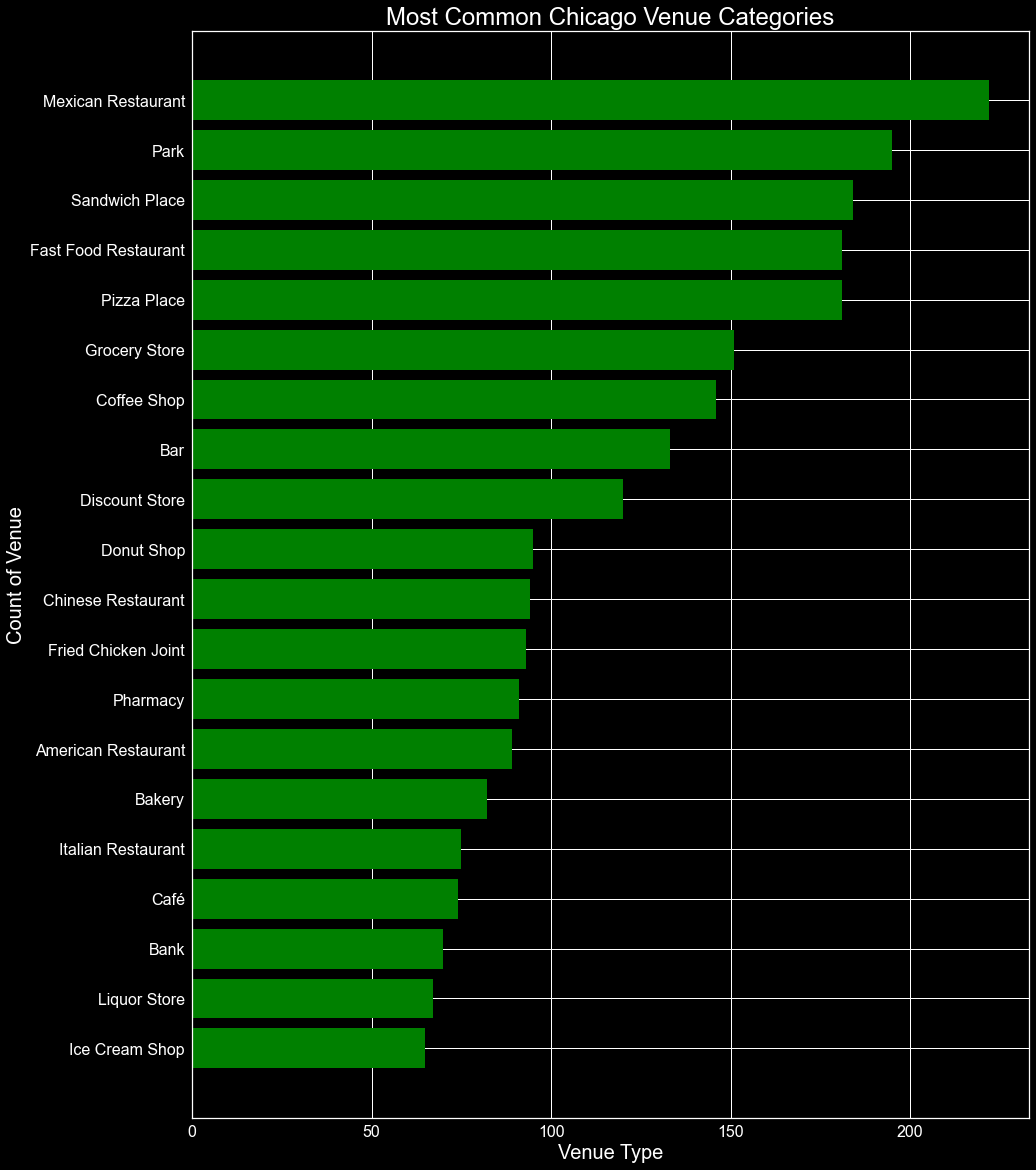

In [73]:
plt.style.use(['dark_background'])

v=[]
d=[]
for x in range(len(ven_freq)-1,-1,-1):
    v.append(ven_freq[x][0])
    d.append(ven_freq[x][1])

fig = plt.figure(figsize=(15,20))
plt.barh(v,d,color='green')
plt.title('Most Common Chicago Venue Categories', fontsize=24)
plt.xlabel('Venue Type', fontsize=20)
plt.ylabel('Count of Venue', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

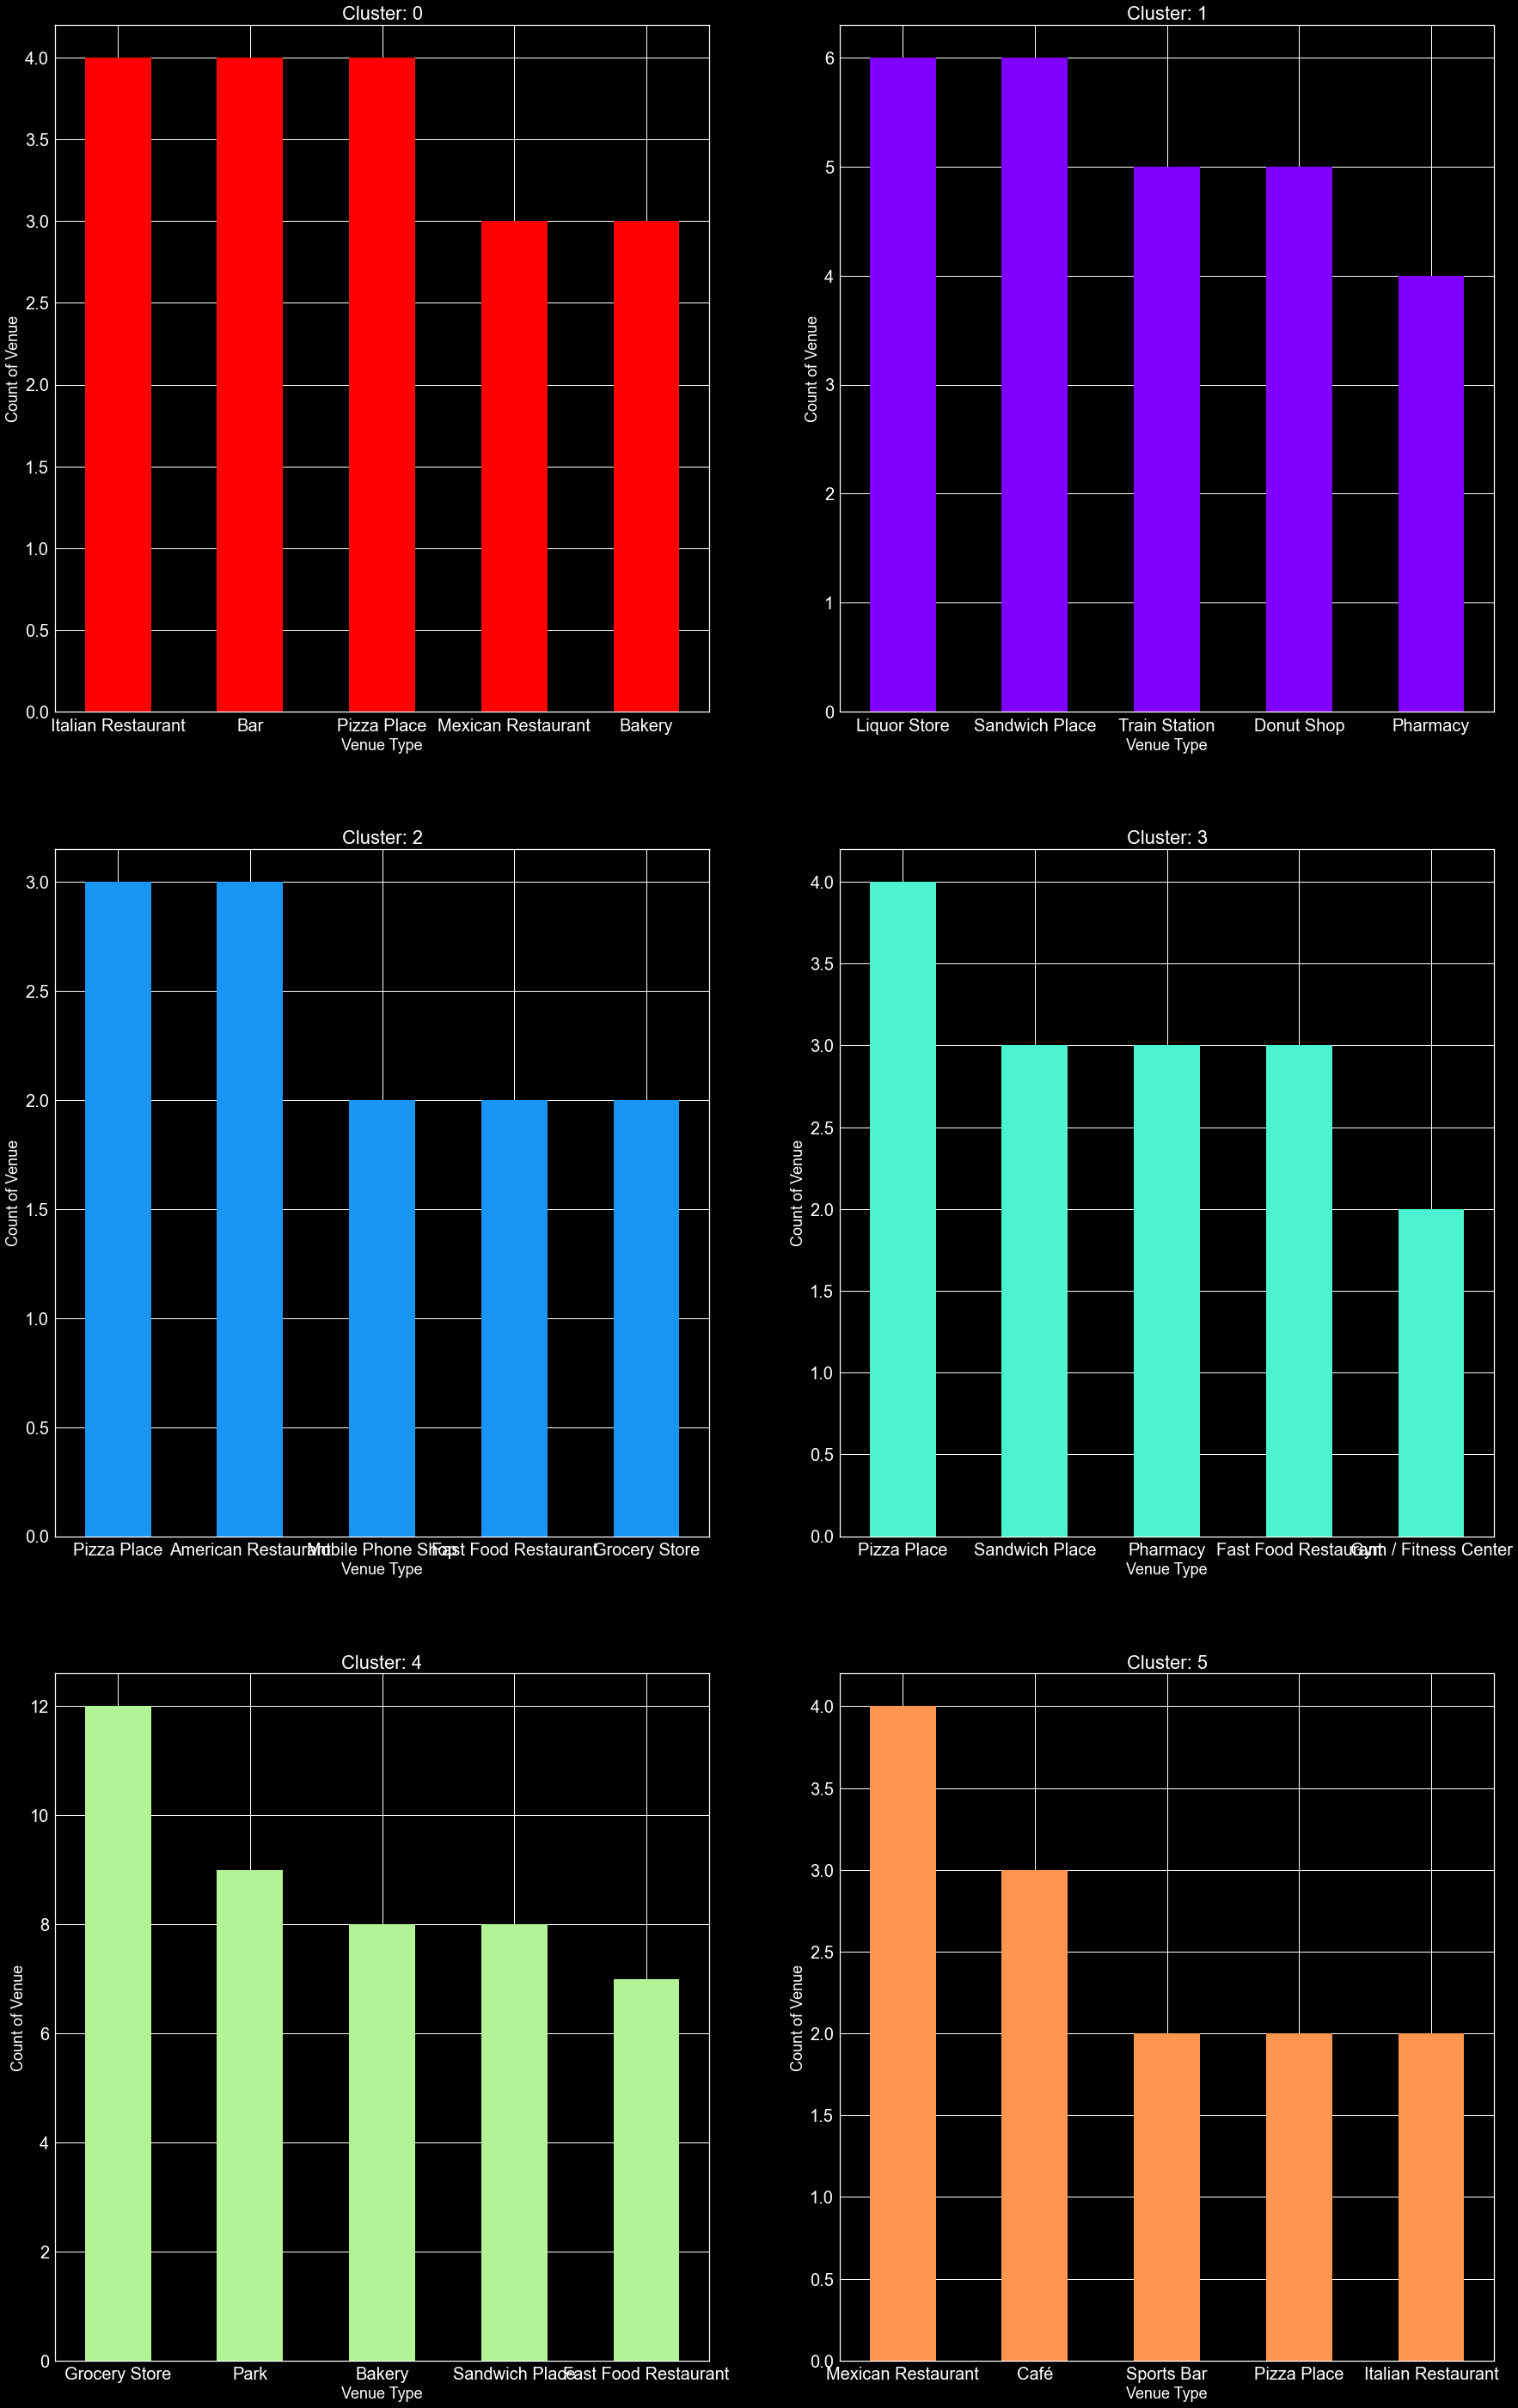

In [74]:
fig, ax = plt.subplots(3,2, figsize=(30,50))

i = 0
j = 0
for z in range(0, 6):
    clus = z
    v = []
    d = []
    for x in range(0, len(v_lst[clus])):
        v.append(v_lst[clus][x][0])
        d.append(v_lst[clus][x][1])

    ax[i,j].bar(v, d, color=rainbow[clus-1],width=0.5)
    ax[i,j].set_title('Cluster: ' + str(clus), fontsize=22)
    ax[i,j].set_xlabel('Venue Type', fontsize=18)
    ax[i,j].set_ylabel('Count of Venue', fontsize=18)
    ax[i,j].tick_params(axis='x', labelsize=20)
    ax[i,j].tick_params(axis='y', labelsize=20)
    if j == 0:
        j = 1
    else:
        j = 0
        i = i+1